# Comparing mokapot to Percolator from the command line

In this vignette, we will run mokapot and Percolator on the same dataset. Because mokapot is a Python implementation of the Percolator algorithm, we expect them to yield similar results. We've performed these analyses within a [Jupyter notebook](https://jupyter.org/), which is available using the download link at the top of the page.

## Following along locally

To run this notebook, you'll need to both have [mokapot](https://mokapot.readthedocs.io/en/latest/#installation) and [Percolator](https://github.com/percolator/percolator/wiki/Download-and-Install) installed. Additionally, you'll need to have a file in the [Percolator tab-delimited format](https://github.com/percolator/percolator/wiki/Interface#tab-delimited-file-format) on hand. The example we'll be using comes from running [Tide-search](http://crux.ms/tide-search) on a single phosphoproteomics experiment from: 

> Hogrebe, Alexander et al. “Benchmarking common quantification strategies for large-scale phosphoproteomics.” Nature communications vol. 9,1 1045. 13 Mar. 2018, doi:10.1038/s41467-018-03309-6

If you need it, you can download it from the mokapot repository here ([phospho_rep1.pin](https://github.com/wfondrie/mokapot/raw/master/data/phosho_rep1.pin)) and set the path to your input file:

In [11]:
pin_file = "../../../data/phospho_rep1.pin"

## Preparing our environment

Before we can proceed to our analyses, we'll need to load a few Python packages that will be used at various places throughout this vignette. All of these packages either come standard with Python or are installed with mokapot.

In [2]:
import os                       # For file paths
import numpy as np              # For math
import pandas as pd             # To load and work with the results
import matplotlib.pyplot as plt # To plot the results

import mokapot

We also need to create output directories for our results:

In [3]:
out_dir = "percolator_comparison_output"
os.makedirs(out_dir, exist_ok=True)

## Analyze PSMs with Percolator

We'll start by performing a simple analysis with Percolator. This will result in two files, containing the confidence estimates for the PSMs and peptides:  

In [4]:
!percolator {pin_file} --results-psms {out_dir}/percolator.psms.txt \
                       --results-peptides {out_dir}/percolator.peptides.txt \
                       --post-processing-tdc # Use target decoy competition instead of mix-max.

Percolator version 3.05.0, Build Date May 18 2020 08:43:48
Copyright (c) 2006-9 University of Washington. All rights reserved.
Written by Lukas Käll (lukall@u.washington.edu) in the
Department of Genome Sciences at the University of Washington.
Issued command:
percolator ../../../data/phospho_rep1.pin --results-psms percolator_comparison_output/percolator.psms.txt --results-peptides percolator_comparison_output/percolator.peptides.txt --post-processing-tdc
Started Fri Jul 10 00:12:30 2020
Hyperparameters: selectionFdr=0.01, Cpos=0, Cneg=0, maxNiter=10
Reading tab-delimited input from datafile ../../../data/phospho_rep1.pin
Features:
deltLCn deltCn RefactoredXCorr NegLog10PValue NegLog10ResEvPValue NegLog10CombinePValue PepLen Charge1 Charge2 Charge3 Charge4 Charge5 enzN enzC enzInt lnNumDSP dM absdM 
Found 110796 PSMs
Separate target and decoy search inputs detected, using target-decoy competition on Percolator scores.
Train/test set contains 55398 positives and 55398 negatives, size r

*Note that a command starting with a `!` is just a way to run terminal commands within a Jupyter notebook. Likewise, {} is used to insert a Python variable into the command.*

## Analyze PSMs with mokapot

Now let's analyze the same dataset using mokapot. When you use mokapot from the command line, the underlying models attempt to replicate the linear support vector machine (SVM) models that Percolator uses.

In [5]:
!mokapot {pin_file} --dest_dir {out_dir}

[INFO] mokapot version 0.1.dev73+g5828013.d20200708
[INFO] Written by William E. Fondrie (wfondrie@uw.edu) in the
[INFO] Department of Genome Sciences at the University of Washington.
[INFO] Command issued:
[INFO] /usr/local/Caskroom/miniconda/base/bin/mokapot ../../../data/phospho_rep1.pin --dest_dir percolator_comparison_output
[INFO] 
[INFO] Starting Analysis
[INFO] =================
[INFO] Parsing PSMs...
[INFO] Reading ../../../data/phospho_rep1.pin...
[INFO] NumExpr defaulting to 8 threads.
[INFO] Using 18 features:
[INFO]   (1)	deltLCn
[INFO]   (2)	deltCn
[INFO]   (3)	RefactoredXCorr
[INFO]   (4)	NegLog10PValue
[INFO]   (5)	NegLog10ResEvPValue
[INFO]   (6)	NegLog10CombinePValue
[INFO]   (7)	PepLen
[INFO]   (8)	Charge1
[INFO]   (9)	Charge2
[INFO]   (10)	Charge3
[INFO]   (11)	Charge4
[INFO]   (12)	Charge5
[INFO]   (13)	enzN
[INFO]   (14)	enzC
[INFO]   (15)	enzInt
[INFO]   (16)	lnNumDSP
[INFO]   (17)	dM
[INFO]   (18)	absdM
[INFO] Found 110796 PSMs.
[INFO]   - 55398 target PSMs and 

## Compare the mokapot and Percolator results

Now that we've analyzed the PSMs using both mokapot and Percolator, we can plot the scores and confidence estimates to see how well they agree.

Let's start by comparing them at the PSM level. First we need to parse the result files for mokapot and Percolator, then combine them into one table:

In [6]:
# Read the result files:
perc_psms = mokapot.read_percolator(os.path.join(out_dir, "percolator.psms.txt"))
moka_psms = pd.read_table(os.path.join(out_dir, "mokapot.psms.txt"))

# Change column names so we can merge tables:
perc_psms = perc_psms.rename(
    columns={"PSMId": "SpecId", 
             "peptide": "Peptide",
             "proteinIds": "Proteins",
             "score": "percolator score",
             "q-value": "percolator q-value",
             "posterior_error_prob": "percolator PEP"})

# Merge the result files.
psms = pd.merge(moka_psms, perc_psms)
psms.head()

,SpecId,Label,ScanNr,ExpMass,CalcMass,Peptide,Proteins,mokapot score,mokapot q-value,mokapot PEP,percolator score,percolator q-value,percolator PEP
0,target_0_52110_3_-1,True,52110,3311.5344,3311.5339,K.EAESCDCLQGFQLTHSLGGGTGSGMGTLLLSK.I,sp|Q3ZCM7|TBB8_HUMAN,10.480832,0.000044,6.305117e-16,10.07360,0.000044,6.305120e-16
1,target_0_41715_3_-1,True,41715,4473.8359,4473.8286,K.ALGKYGPADVEDTTGSGATDSKDDDDIDLFGS[79.97]DDEEE...,sp|P24534|EF1B_HUMAN,10.215858,0.000044,6.305117e-16,9.90914,0.000044,6.305120e-16
2,target_0_40746_5_-1,True,40746,5586.4609,5586.4536,K.KLVHNALANLDGHPEDKPTHIIFGS[79.97]DS[79.97]ECE...,sp|Q76FK4|NOL8_HUMAN,10.014401,0.000044,6.305117e-16,9.69423,0.000044,6.305120e-16
3,target_0_35254_3_-1,True,35254,3606.6274,3606.6301,K.KLPPPPPQAPPEEENES[79.97]EPEEPSGVEGAAFQSR.L,sp|O60341|KDM1A_HUMAN,9.236619,0.000044,6.305117e-16,8.96354,0.000044,6.305120e-16
4,target_0_34845_3_-1,True,34845,3606.6318,3606.6301,K.KLPPPPPQAPPEEENES[79.97]EPEEPSGVEGAAFQSR.L,sp|O60341|KDM1A_HUMAN,9.231946,0.000044,6.305117e-16,9.00122,0.000044,6.305120e-16


Fortunately, we can see that a nearly identical number of PSMs are accepted at 1% FDR:

In [7]:
perc_passing = (psms["percolator q-value"] <= 0.01).sum()
moka_passing = (psms["mokapot q-value"] <= 0.01).sum()
print(f"Percolator found {perc_passing} PSMs at 1% FDR.")
print(f"mokapot found {moka_passing} PSMs at 1% FDR.")

Percolator found 27766 PSMs at 1% FDR.
mokapot found 27810 PSMs at 1% FDR.


We can make some plots to see how the PSM scores and confidence estimates compare to one another. First, we'll define a simple plotting function for our comparisons:

In [8]:
def comparison_plot(x, y, ax=None):
    """
    Create a scatter plot with equal axis scales.
    
    Plot x against y, where the axis limits are scaled 
    to be equal. Additionally a y=x line is added.
    
    Parameters
    ----------
    x, y : numpy.ndarray
        The points to plot
    ax : matplotlib.axes.Axes
        The matplotlib axes to plot on.
        
    Returns
    -------
    matplotlib.axes.Axes
        The axes with the plot.
    """
    if ax is None:
        ax = plt.gca()
        
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f"Pearson's r = {corr:0.4f}", 
            transform=ax.transAxes, va="top")
    ax.scatter(x, y, s=10, alpha=0.1, edgecolor="", c="#24B8A0")
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, c="black", zorder=0, linewidth=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

Now we can look at how well the scores, q-values, and posterior error probabilities (PEPs) correlate between mokapot and Percolator. Here are the PSMs:

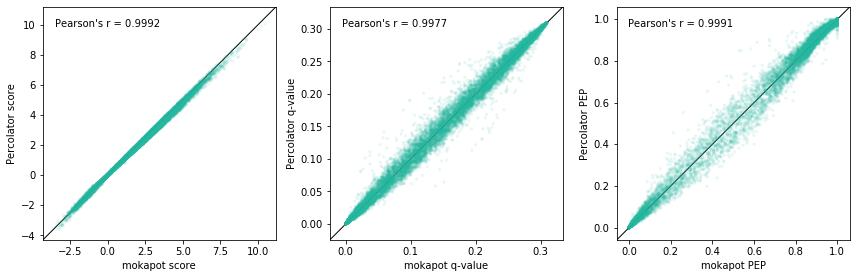

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
comparison_plot(psms["mokapot score"], psms["percolator score"], axs[0])
comparison_plot(psms["mokapot q-value"], psms["percolator q-value"], axs[1])
comparison_plot(psms["mokapot PEP"], psms["percolator PEP"], axs[2])

for ax, lab in zip(axs, ["score", "q-value", "PEP"]):
    ax.set_xlabel(f"mokapot {lab}")
    ax.set_ylabel(f"Percolator {lab}")
    
plt.tight_layout()
plt.show()

We can also do the same for peptides:

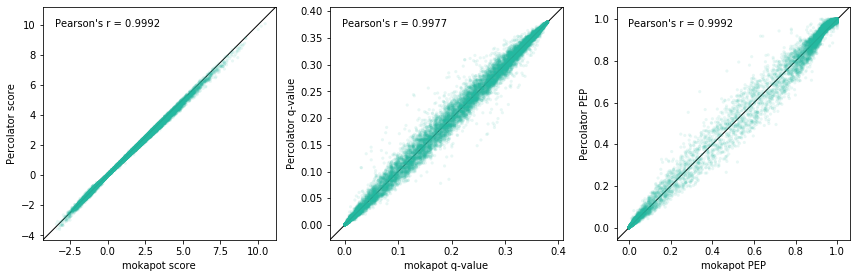

In [10]:
# Read the result files:
perc_peps = mokapot.read_percolator(os.path.join(out_dir, "percolator.peptides.txt"))
moka_peps = pd.read_table(os.path.join(out_dir, "mokapot.peptides.txt"))

# Change column names so we can merge tables:
perc_peps = perc_peps.rename(
    columns={"PSMId": "SpecId", 
             "peptide": "Peptide",
             "proteinIds": "Proteins",
             "score": "percolator score",
             "q-value": "percolator q-value",
             "posterior_error_prob": "percolator PEP"})

# Merge the result files:
peps = pd.merge(moka_peps, perc_peps)

# Plot the results:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
comparison_plot(peps["mokapot score"], peps["percolator score"], axs[0])
comparison_plot(peps["mokapot q-value"], peps["percolator q-value"], axs[1])
comparison_plot(peps["mokapot PEP"], peps["percolator PEP"], axs[2])

for ax, lab in zip(axs, ["score", "q-value", "PEP"]):
    ax.set_xlabel(f"mokapot {lab}")
    ax.set_ylabel(f"Percolator {lab}")
    
plt.tight_layout()
plt.show()

## Wrapping up

As you can see from the plots above, the results from mokapot and Percolator were highly correlated. In fact, the variability that we observed is largely due to the stochastic step in the Percolator algorithm: PSMs are randomly assigned to cross-validation folds for analysis. Because of this, you can observe similar variability between Percolator results when run with different random seeds.

In this vignette, we've run Percolator and mokapot from the command line then made plots to compare their results using Python. While mokapot can emulate much of Percolator's functionality from the command line, much more flexibility is unlocked when using it as a Python package. Be sure to check out our other vignettes to learn more.